# `banyan` Example 2: Training

This notebook goes through the full exercise of training a BNN on data.

## Python Preamble

Imports etc.

In [1]:
from banyan import BNN, BLoss

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau as ReduceLR
from torch.utils.data import DataLoader, TensorDataset

rng = np.random.default_rng(42)

## Premise

Here I describe a 2-dimensional (1 input $x$, 1 output $y$) problem. The mean $\mu$ and scatter $\sigma$ of $y$ depend on $x$ as follows: 

In [2]:
def mu_true(x):
    return x - 0.5

def sig_true(x):
    return 2 * np.abs(x) / 3 + 0.5

To visualise this:

Text(0, 0.5, '$y$')

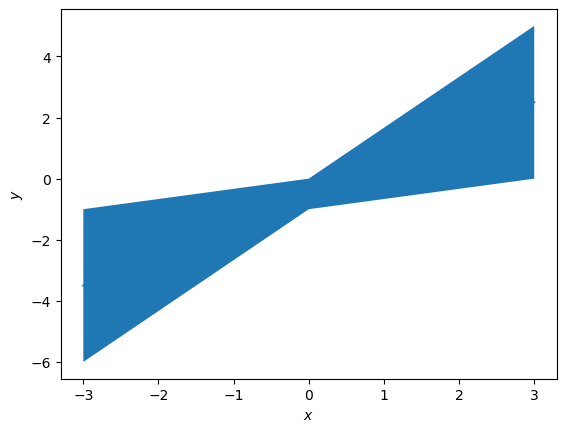

In [3]:
x = np.linspace(-3, 3, 500)
plt.plot(x, mu_true(x))
plt.fill_between(x, mu_true(x) - sig_true(x), mu_true(x) + sig_true(x))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

The idea is to sample a dataset following this relation, and train a BNN from it. The BNN should not only learn $\mu(x)$ but also $\sigma(x)$

## Data

Here I generate a mock dataset following the above relation, with inputs $x\in [-3, 3]$.

In [4]:
N_data = 100000

x = torch.tensor(rng.uniform(low=-3, high=3, size=(N_data, 1)))
y = torch.tensor(rng.normal(loc=mu_true(x), scale=sig_true(x)))

To visualise dataset, with true relations overplotted:

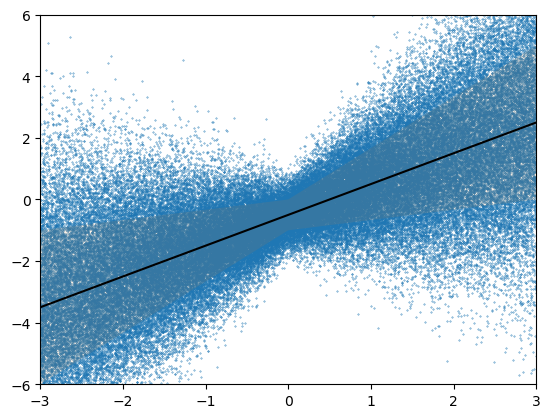

In [5]:
x_plot = np.linspace(-3, 3, 500)
mu_plot = mu_true(x_plot)
sig_plot = sig_true(x_plot)

plt.scatter(x, y, s=0.1)
plt.ylim(-6, 6)
plt.xlim(-3, 3)
plt.plot(x_plot, mu_plot, c='k')
plt.fill_between(x_plot, mu_plot-sig_plot, mu_plot+sig_plot, alpha=0.1)

## Set up model

Because the loss function can involve exponentials of large negative numbers, double precision is safer.

In [6]:
model = BNN(1, 1, 2, 8).double()
lossfn = BLoss()

## Train

In [7]:
N_batch = 1000
N_samples = 10

optim = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLR(optim, factor=0.5, min_lr=1e-5, threshold=1e-5, cooldown=5)
loader = DataLoader(TensorDataset(x, y), batch_size=N_batch, shuffle=True, drop_last=True, pin_memory=True)

In [9]:
for i in range(20):

    # loop over train batches
    model.train()
    losses = np.array([])
    for x, y in loader:
        optim.zero_grad()
        preds = model(x, N_samples)
        loss = lossfn(preds, y)
        losses = np.append(losses, loss.item())
        loss.backward()
        optim.step()

    # step scheduler
    avg_loss = np.mean(losses)
    scheduler.step(avg_loss)

    print(i, avg_loss)
    
    model.eval()

0 2.002383423204373
1 1.9559997945932057
2 1.9195389358878734
3 1.9057218993223821
4 1.8984650399799166
5 1.892019789928412
6 1.885708819226316
7 1.8890836100859778
8 1.8819603895880415
9 1.8882356390575687
10 1.8848379914914717
11 1.8828679627657994
12 1.8846705466131204
13 1.8844581829726155
14 1.881447701755616
15 1.8804463257726582
16 1.8849713702518474
17 1.8817907397651432
18 1.8813627056528224
19 1.8810905057701144


In [10]:
x

tensor([[-9.3551e-01],
        [-2.9280e+00],
        [-3.3291e-01],
        [-7.2213e-01],
        [ 1.3289e+00],
        [-2.1293e+00],
        [-1.1549e+00],
        [-1.8172e+00],
        [-1.8585e+00],
        [ 6.6771e-01],
        [ 5.8212e-01],
        [-1.8914e-01],
        [-2.5477e-03],
        [-1.6214e-01],
        [ 1.3109e+00],
        [-2.3270e+00],
        [-7.3344e-01],
        [ 2.6595e+00],
        [ 3.0769e-01],
        [ 2.8636e+00],
        [ 2.3222e+00],
        [ 1.9185e+00],
        [ 1.9063e+00],
        [-6.1919e-01],
        [-2.3676e+00],
        [-1.4163e+00],
        [-1.8214e+00],
        [ 1.1063e+00],
        [ 2.9144e+00],
        [ 1.8528e+00],
        [-2.9919e+00],
        [ 3.8338e-01],
        [ 1.7048e+00],
        [-2.3846e+00],
        [-1.7511e+00],
        [ 1.2883e+00],
        [-2.3164e+00],
        [-2.7818e+00],
        [-5.8281e-01],
        [ 7.5198e-02],
        [-1.7490e+00],
        [ 1.4915e+00],
        [ 2.0627e+00],
        [-2